![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/nlu/blob/master/examples/colab/Training/multi_label_text_classification/NLU_training_multi_token_label_text_classifier_stackoverflow_tags.ipynb)



# Training a Deep Learning Classifier for sentences with multiple classes at the same time 
MultiClassifierDL is a Multi-label Text Classification. MultiClassifierDL uses a Bidirectional GRU with Convolution model that we have built inside TensorFlow and supports up to 100 classes. The input to MultiClassifierDL is Sentence Embeddings such as state-of-the-art UniversalSentenceEncoder, BertSentenceEmbeddings, or SentenceEmbeddings



### Multi ClassifierDL (Multi-class Text Classification with multiple classes per sentence)
With the [ClassifierDL model](https://nlp.johnsnowlabs.com/docs/en/annotators#multiclassifierdl-multi-label-text-classification) from Spark NLP you can achieve State Of the Art results on any multi class text classification problem 

This notebook showcases the following features : 

- How to train the deep learning classifier
- How to store a pipeline to disk
- How to load the pipeline from disk (Enables NLU offline mode)



# 1. Install Java 8 and NLU

In [ ]:
!wget https://setup.johnsnowlabs.com/nlu/colab.sh -O - | bash
  

import nlu

# 2 Download sample dataset 60k Stack Overflow Questions with Quality Rating


https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate

In [ ]:
import pandas as pd
! wget -N https://ckl-it.de/wp-content/uploads/2020/11/60kstackoverflow.csv -P /tmp
test_path = '/tmp/60kstackoverflow.csv'
train_df = pd.read_csv(test_path)

--2021-01-02 11:20:29--  https://ckl-it.de/wp-content/uploads/2020/11/60kstackoverflow.csv
Resolving ckl-it.de (ckl-it.de)... 217.160.0.108, 2001:8d8:100f:f000::209
Connecting to ckl-it.de (ckl-it.de)|217.160.0.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50356825 (48M) [text/csv]
Saving to: ‘/tmp/60kstackoverflow.csv’

60kstackoverflow.cs 100%[===================>]  48.02M  2.57MB/s    in 21s     

2021-01-02 11:20:51 (2.32 MB/s) - ‘/tmp/60kstackoverflow.csv’ saved [50356825/50356825]



In [ ]:
# Split labels and clean them.
import pandas as pd

train_df = pd.read_csv(test_path)

f = lambda x : x.replace('<','').replace('>','')
g = lambda l : list(map(f,l))
train_df['y'] = train_df.Tags.str.split('><').map(g).str.join(',')
train_df['text'] = train_df['Title']

 
# train_df = train_df.iloc[:50]

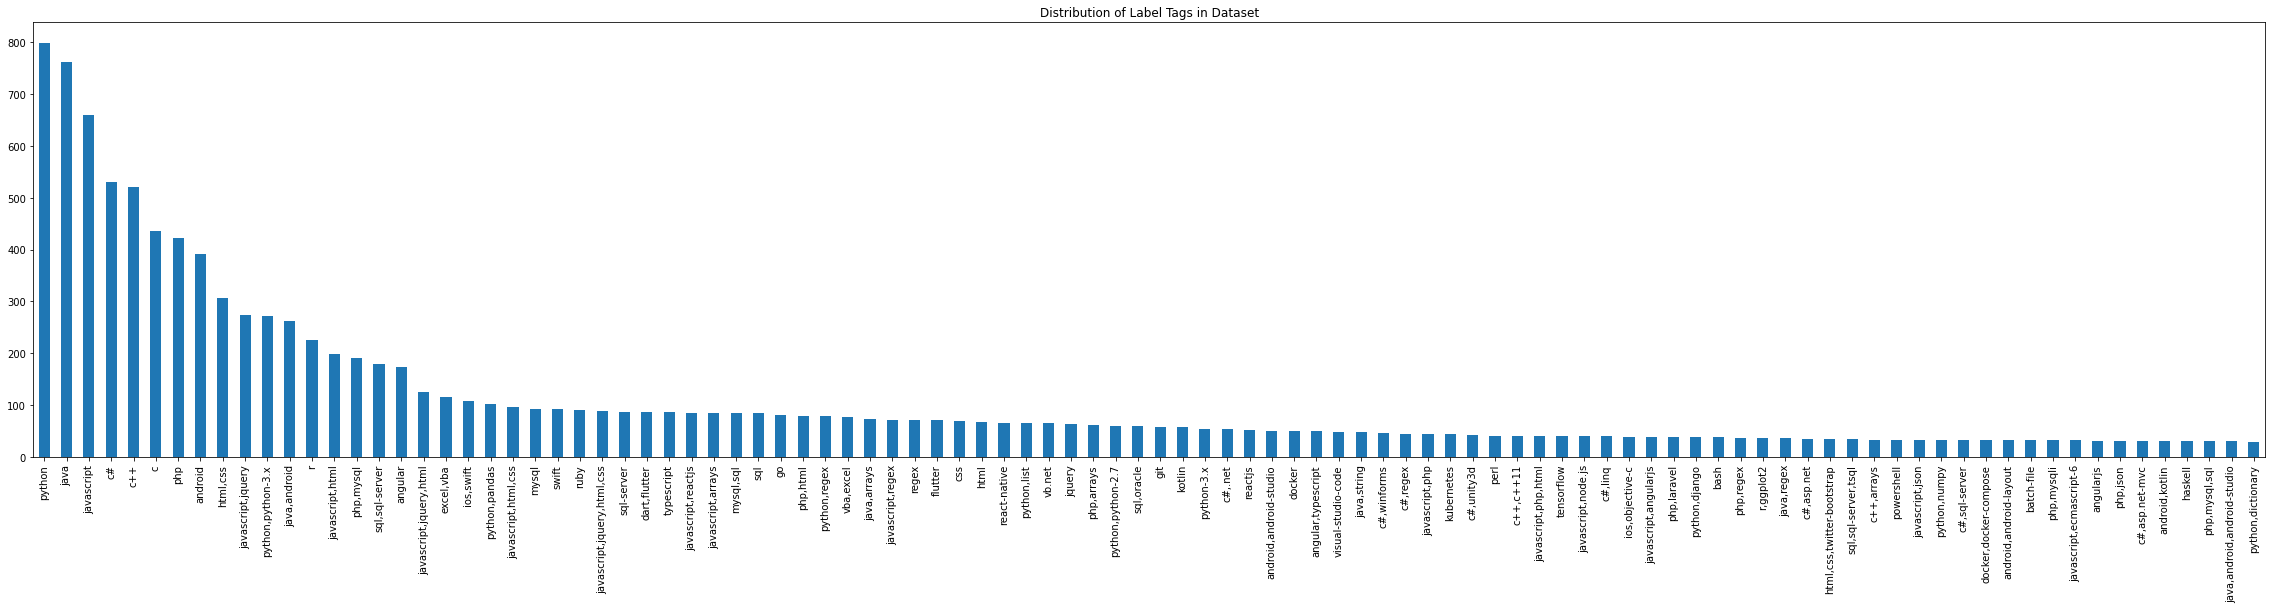

In [ ]:
counts = train_df.explode('y').y.value_counts()
counts.iloc[0:100].plot.bar(figsize=(40,8), title='Distribution of Label Tags in Dataset')

In [ ]:
exp = train_df.y.str.split(',').explode().value_counts()
top_100_tags = list(exp[0:25].index)
# z = lambda r : True if r.split(',') in top_100_tags else False
z = lambda r : True if all(x in top_100_tags for x in r.split(',') ) else False
top_100_idx = train_df.y.map(z)
train_df = train_df[top_100_idx]
train_df

,Id,Title,Body,Tags,CreationDate,Y,y,text
13,34556906,"output FILE ,is this a fault?",\r\nmy code here\r\n\r\n #include <stdi...,<c++>,2016-01-01 14:20:01,LQ_EDIT,c++,"output FILE ,is this a fault?"
24,34560768,Can I throw from class init() in Swift with co...,<p>I'd like my class <em>init()</em> in Swift ...,<swift>,2016-01-01 22:42:24,HQ,swift,Can I throw from class init() in Swift with co...
25,34560942,C# - Count a specific word in richTextBox1 and...,"<p>I'm not sure, if this question is unique, b...",<c#>,2016-01-01 23:06:53,LQ_CLOSE,c#,C# - Count a specific word in richTextBox1 and...
30,34562551,c++ vector type function implemetation,class City\r\n {\r\n private:\r\n...,<c++>,2016-01-02 04:17:27,LQ_EDIT,c++,c++ vector type function implemetation
48,34566364,japanese and portuguese language cannot support,My site Japanese supported. But Portuguese la...,<php>,2016-01-02 13:20:49,LQ_EDIT,php,japanese and portuguese language cannot support
...,...,...,...,...,...,...,...,...
44992,60458575,MySQL how to query five tables in one SELECT,<p>I have 5 tables as follows:</p>\n\n<ul>\n<l...,<mysql>,2020-02-28 20:07:09,LQ_CLOSE,mysql,MySQL how to query five tables in one SELECT
44993,60460748,Copy value of list not reference,<p>I have a list that i want to compare to aft...,<python>,2020-02-28 23:54:33,LQ_CLOSE,python,Copy value of list not reference
44994,60461193,"Weird question, but how do I make a python scr...","<p>Before you get confused, I am going to comp...",<python><python-3.x>,2020-02-29 01:25:40,LQ_CLOSE,"python,python-3.x","Weird question, but how do I make a python scr..."
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE,python,Does Python execute code from the top or botto...


In [ ]:
import nlu
# load a trainable pipeline by specifying the train  prefix 

unfitted_pipe = nlu.load('train.multi_classifier')
#configure epochs
unfitted_pipe['multi_classifier'].setMaxEpochs(100)
unfitted_pipe['multi_classifier'].setLr(0.005)      
#  fit it on a datset with label='y' and text columns. Labels seperated by ','
fitted_pipe = unfitted_pipe.fit(train_df[['y','text']], label_seperator=',')

# predict with the trained pipeline on dataset and get predictions
preds = fitted_pipe.predict(train_df[['y','text']])
preds

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


,y,text,multi_classifier_confidences,sentence,default_name_embeddings,multi_classifier_classes
origin_index,,,,,,
13,c++,"output FILE ,is this a fault?",[],"output FILE ,is this a fault?","[0.04620636999607086, -0.04046135023236275, -0...",[]
24,swift,Can I throw from class init() in Swift with co...,"[0.86285734, 0.98327714]",Can I throw from class init() in Swift with co...,"[0.053270746022462845, -0.00784565694630146, -...","[swift, c]"
25,c#,C# - Count a specific word in richTextBox1 and...,[0.64955217],C# - Count a specific word in richTextBox1 and...,"[-0.005682709161192179, -0.023547030985355377,...",[regex]
30,c++,c++ vector type function implemetation,"[0.9755105, 0.77180904, 0.9789763]",c++ vector type function implemetation,"[0.024628309532999992, -0.015623562969267368, ...","[c++, python-3.x, python]"
48,php,japanese and portuguese language cannot support,[0.55255216],japanese and portuguese language cannot support,"[0.038325726985931396, -0.005848723463714123, ...",[php]
...,...,...,...,...,...,...
44992,mysql,MySQL how to query five tables in one SELECT,"[0.6404308, 0.99544823]",MySQL how to query five tables in one SELECT,"[0.006962132174521685, -0.03580842167139053, -...","[sql, mysql]"
44993,python,Copy value of list not reference,[0.591653],Copy value of list not reference,"[0.025995030999183655, 0.001833591377362609, -...",[javascript]
44994,"python,python-3.x","Weird question, but how do I make a python scr...","[0.7427199, 0.99999976, 0.70473063, 0.72811186...","Weird question, but how do I make a python scr...","[0.018493961542844772, -0.04660267382860184, -...","[html, python, javascript, node.js, php]"


# 4. Evaluate the model

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
mlb = MultiLabelBinarizer()
mlb = mlb.fit(preds.y.str.split(','))
y_true = mlb.transform(preds['y'].str.split(','))
y_pred = mlb.transform(preds.multi_classifier_classes.str.join(',').str.split(','))
print("Classification report: \n", (classification_report(y_true, y_pred)))
print("F1 micro averaging:",(f1_score(y_true, y_pred, average='micro')))
print("ROC: ",(roc_auc_score(y_true, y_pred, average="micro")))

Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.80      0.73       840
           1       0.22      0.62      0.32       237
           2       0.37      0.47      0.41       467
           3       0.38      0.67      0.49       561
           4       0.48      0.54      0.51       831
           5       0.54      0.58      0.56       697
           6       0.49      0.73      0.59       792
           7       0.58      0.39      0.47      1352
           8       0.20      0.18      0.19       158
           9       0.49      0.77      0.60      1431
          10       0.57      0.75      0.65      2343
          11       0.36      0.56      0.43       833
          12       0.34      0.24      0.28       300
          13       0.51      0.74      0.60       539
          14       0.19      0.28      0.23       106
          15       0.63      0.67      0.65      1283
          16       0.61      0.74      0.67      1402
  

# 5. Lets try different Sentence Emebddings

In [ ]:
# We can use nlu.print_components(action='embed_sentence') to see every possibler sentence embedding we could use. Lets use bert!
nlu.print_components(action='embed_sentence')

For language <en> NLU provides the following Models : 
nlu.load('en.embed_sentence') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.tfhub_use') returns Spark NLP model tfhub_use
nlu.load('en.embed_sentence.use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.tfhub_use.lg') returns Spark NLP model tfhub_use_lg
nlu.load('en.embed_sentence.albert') returns Spark NLP model albert_base_uncased
nlu.load('en.embed_sentence.electra') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_small_uncased') returns Spark NLP model sent_electra_small_uncased
nlu.load('en.embed_sentence.electra_base_uncased') returns Spark NLP model sent_electra_base_uncased
nlu.load('en.embed_sentence.electra_large_uncased') returns Spark NLP model sent_electra_large_uncased
nlu.load('en.embed_sentence.bert') returns Spark NLP model sent_bert_base_uncased
nlu.load('en.embed_sentenc

In [ ]:
pipe = nlu.load('en.embed_sentence.small_bert_L12_768 train.multi_classifier')
pipe.print_info()

sent_small_bert_L12_768 download started this may take some time.
Approximate size to download 392.9 MB
[OK!]
The following parameters are configurable for this NLU pipeline (You can copy paste the examples) :
>>> pipe['en_embed_sentence_small_bert_L12_768'] has settable params:
pipe['en_embed_sentence_small_bert_L12_768'].setBatchSize(32)  | Info: Batch size. Large values allows faster processing but requires more memory. | Currently set to : 32
pipe['en_embed_sentence_small_bert_L12_768'].setIsLong(False)  | Info: Use Long type instead of Int type for inputs buffer - Some Bert models require Long instead of Int. | Currently set to : False
pipe['en_embed_sentence_small_bert_L12_768'].setMaxSentenceLength(128)  | Info: Max sentence length to process | Currently set to : 128
pipe['en_embed_sentence_small_bert_L12_768'].setDimension(768)  | Info: Number of embedding dimensions | Currently set to : 768
pipe['en_embed_sentence_small_bert_L12_768'].setCaseSensitive(False)  | Info: whether t

In [ ]:
# Load pipe with bert embeds
# using large embeddings can take a few hours..
pipe['multi_classifier'].setMaxEpochs(120)            
pipe['multi_classifier'].setLr(0.0005)  
fitted_pipe = pipe.fit(train_df[['y','text']],label_seperator=',')
preds = fitted_pipe.predict(train_df[['y','text']])
preds

,y,text,multi_classifier_confidences,en_embed_sentence_small_bert_L12_768_embeddings,document,multi_classifier_classes
origin_index,,,,,,
13,c++,"output FILE ,is this a fault?",[],"[-0.0598912313580513, 0.429191917181015, -0.25...","output FILE ,is this a fault?",[]
24,swift,Can I throw from class init() in Swift with co...,[0.61310124],"[-0.45358699560165405, 0.1986018270254135, -0....",Can I throw from class init() in Swift with co...,[java]
25,c#,C# - Count a specific word in richTextBox1 and...,[0.8172003],"[-0.592096209526062, 0.0025841565802693367, -0...",C# - Count a specific word in richTextBox1 and...,[c#]
30,c++,c++ vector type function implemetation,[0.98100495],"[-0.6645137071609497, 0.34700289368629456, 0.1...",c++ vector type function implemetation,[c++]
48,php,japanese and portuguese language cannot support,[],"[-0.30820634961128235, 0.5732622742652893, 0.5...",japanese and portuguese language cannot support,[]
...,...,...,...,...,...,...
44992,mysql,MySQL how to query five tables in one SELECT,[0.94582915],"[-0.6759300231933594, 0.1323285549879074, 0.56...",MySQL how to query five tables in one SELECT,[mysql]
44993,python,Copy value of list not reference,[0.71518165],"[-0.7307966947555542, 0.3146328032016754, -0.5...",Copy value of list not reference,[python]
44994,"python,python-3.x","Weird question, but how do I make a python scr...",[0.9938545],"[-0.478365957736969, -0.015336859039962292, 0....","Weird question, but how do I make a python scr...",[python]


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
mlb = MultiLabelBinarizer()
mlb = mlb.fit(preds.y.str.split(','))
y_true = mlb.transform(preds['y'].str.split(','))
y_pred = mlb.transform(preds.multi_classifier_classes.str.join(',').str.split(','))
print("Classification report: \n", (classification_report(y_true, y_pred)))
print("F1 micro averaging:",(f1_score(y_true, y_pred, average='micro')))
print("ROC: ",(roc_auc_score(y_true, y_pred, average="micro")))

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.67      0.79       738
           1       0.95      0.71      0.82       228
           2       0.70      0.53      0.60       440
           3       0.91      0.63      0.75       508
           4       0.95      0.57      0.71       733
           5       0.91      0.58      0.71       621
           6       0.88      0.70      0.78       736
           7       0.81      0.65      0.72      1254
           8       0.86      0.58      0.69       145
           9       0.89      0.58      0.70      1288
          10       0.87      0.73      0.80      2164
          11       0.89      0.58      0.70       754
          12       0.84      0.67      0.74       277
          13       0.89      0.59      0.71       511
          14       0.96      0.27      0.42        96
          15       0.94      0.70      0.80      1193
          16       0.93      0.70      0.80      1265
  

# 5. Lets save the model

In [ ]:
stored_model_path = './models/multi_classifier_dl_trained' 
fitted_pipe.save(stored_model_path)

Stored model in ./models/multi_classifier_dl_trained


# 6. Lets load the model from HDD.
This makes Offlien NLU usage possible!   
You need to call nlu.load(path=path_to_the_pipe) to load a model/pipeline from disk.

In [ ]:
hdd_pipe = nlu.load(path=stored_model_path)

preds = hdd_pipe.predict('Tesla plans to invest 10M into the ML sector')
preds

In [ ]:
hdd_pipe.print_info()